<a href="https://colab.research.google.com/github/rdemarqui/Data-Science-Basico/blob/master/Whisper_Fine_tunning_Portuguese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whisper Fine-tunning

In [ ]:
# To do
# Dataset
  # ( ) Evaluate before training
  # ( ) Download streaming mode dataset
  # ( ) Merge more than one dataset
  # (x) Transform audio into Mel Spectogram
  # ( ) Data Augmentation
  # ( ) Normalize text
  # ( ) Drop audio > 30s
  # ( ) Drop large embedding
# Train
  # ( ) Save checkpoints
# Evaluate
  # ( ) Evaluate after training (WER)
  # ( ) Compare with leaderboard: https://huggingface.co/spaces/whisper-event/winners?dataset=mozilla-foundation%2Fcommon_voice_11_0
# ( ) Save final model on Huggin Face
# (?) Create a App

In [3]:
# Check Environment
device = !nvidia-smi -L
device = "cuda" if device[0][:3] == 'GPU' else "cpu"
device

'cpu'

In [5]:
# Linking the notebook to the Hugging Face Hub
!pip install huggingface_hub -q
from huggingface_hub import notebook_login
notebook_login()

## Datasets

In [ ]:
!pip install datasets -q
from datasets import load_dataset, DatasetDict

### Test Dataset

In [23]:
# Download test dataset
common_voice = DatasetDict()
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_13_0", "pt", split="test")
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])
print(common_voice)

DatasetDict({
    test: Dataset({
        features: ['audio', 'sentence', 'variant'],
        num_rows: 9072
    })
})


In [ ]:
!pip install ipython -q
from IPython.display import Audio

In [26]:
# Play audio
audio_path = common_voice["test"][90]['audio']['path']

print(common_voice["test"][90]['sentence'], '\n')
Audio(audio_path)

Se você quer ser uma batata, coloque-a em primeiro plano. 



#### Mel Spectogram

In [43]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [51]:
# Load audiofiles with librosa
audio, sampling_rate = librosa.load(audio_path)

In [54]:
# Get mel spectogram from file
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sampling_rate,
                                                 n_fft=2048, hop_length=512,
                                                 n_mels=10)

# Convert to db
log_mel_spectogram = librosa.power_to_db(mel_spectrogram)

(10, 202)

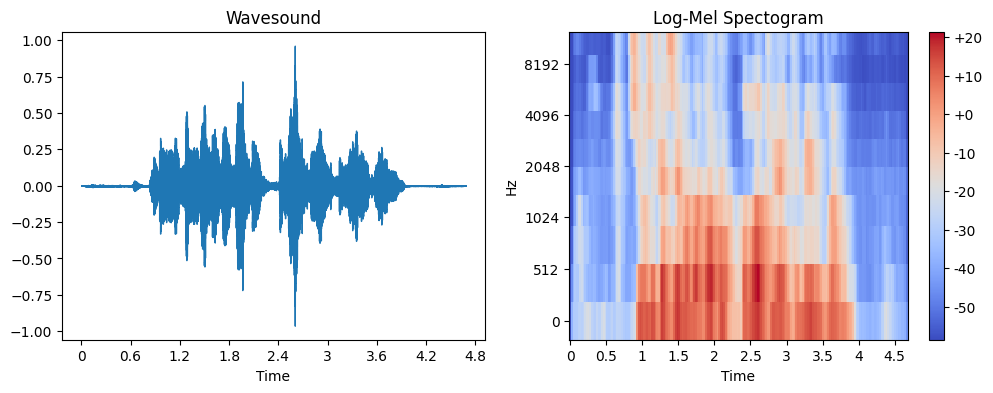

In [76]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
librosa.display.waveshow(audio, sr=sampling_rate)
plt.title("Wavesound")

plt.subplot(1, 2, 2)
librosa.display.specshow(log_mel_spectogram, x_axis='time', y_axis='mel', sr=sampling_rate)
plt.colorbar(format="%+2.f")
plt.title("Log-Mel Spectogram")

plt.show()

### Train Dataset

## Load Model

In [ ]:
! pip install transformers